# YZV311E - TERM PROJECT
Kaan Yücel - 150210318 ---- Ulus Emir Aslan - 150210320

In [ ]:
import pandas as pd
import numpy as np
import ast
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
catalog_df = pd.read_csv('drive/MyDrive/collab_files/product_catalog.csv')
category_map_df = pd.read_csv("/content/drive/MyDrive/collab_files/product_category_map.csv")
transactions_df= pd.read_csv("drive/MyDrive/collab_files/transactions.csv")
test_df= pd.read_csv("drive/MyDrive/collab_files/test.csv")

In [ ]:
print("Shape of catalog_df:", catalog_df.shape)
print("Shape of category_map_df:", category_map_df.shape)
print("Shape of transactions_df:", transactions_df.shape)
print("Shape of test_df:", test_df.shape)

Shape of catalog_df: (32776, 8)
Shape of category_map_df: (4332, 2)
Shape of transactions_df: (1071538, 4)
Shape of test_df: (10000, 4)


##EXPLORATARY DATA ANAYLSIS


In [ ]:
catalog_df.head()


,product_id,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,categories
0,22665,861,4,0,490,2,66,"[2890, 855, 3908, 3909]"
1,28640,1366,10,1,537,0,101,NaN
2,13526,1090,10,0,511,0,0,"[3270, 163, 284, 1694, 12, 3837, 2422, 3595, 3..."
3,21399,1090,10,1,511,0,0,[3270]
4,8504,768,4,1,484,0,66,[2470]


In [ ]:
category_map_df.head()


,category_id,parent_category_id
0,0,75
1,1,1499
2,2,1082
3,3,3498
4,4,1623


In [ ]:
transactions_df.head()


,customer_id,product_id,purchase_date,quantity
0,38769,3477,2020-06-01,1
1,42535,30474,2020-06-01,1
2,42535,15833,2020-06-01,1
3,42535,20131,2020-06-01,1
4,42535,4325,2020-06-01,1


In [ ]:
catalog_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32776 entries, 0 to 32775
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   product_id       32776 non-null  int64 
 1   manufacturer_id  32776 non-null  int64 
 2   attribute_1      32776 non-null  int64 
 3   attribute_2      32776 non-null  int64 
 4   attribute_3      32776 non-null  int64 
 5   attribute_4      32776 non-null  int64 
 6   attribute_5      32776 non-null  int64 
 7   categories       25988 non-null  object
dtypes: int64(7), object(1)
memory usage: 2.0+ MB


It can be seen that 'categories' column has some NULL values.Also -1 values in attributes are considered as NULL


In [ ]:
print("# -1 values in attributes")
for i in range(1,6):
  str1 = 'attribute_'+ str(i)
  print(f"{str1} : {catalog_df[catalog_df[str1]==-1]['product_id'].count()}")
print(f"Manufacturer id : {catalog_df[catalog_df['manufacturer_id']==-1]['product_id'].count()}")

# -1 values in attributes
attribute_1 : 4
attribute_2 : 0
attribute_3 : 466
attribute_4 : 617
attribute_5 : 4264
Manufacturer id : 1


## Visualizing the attribute values

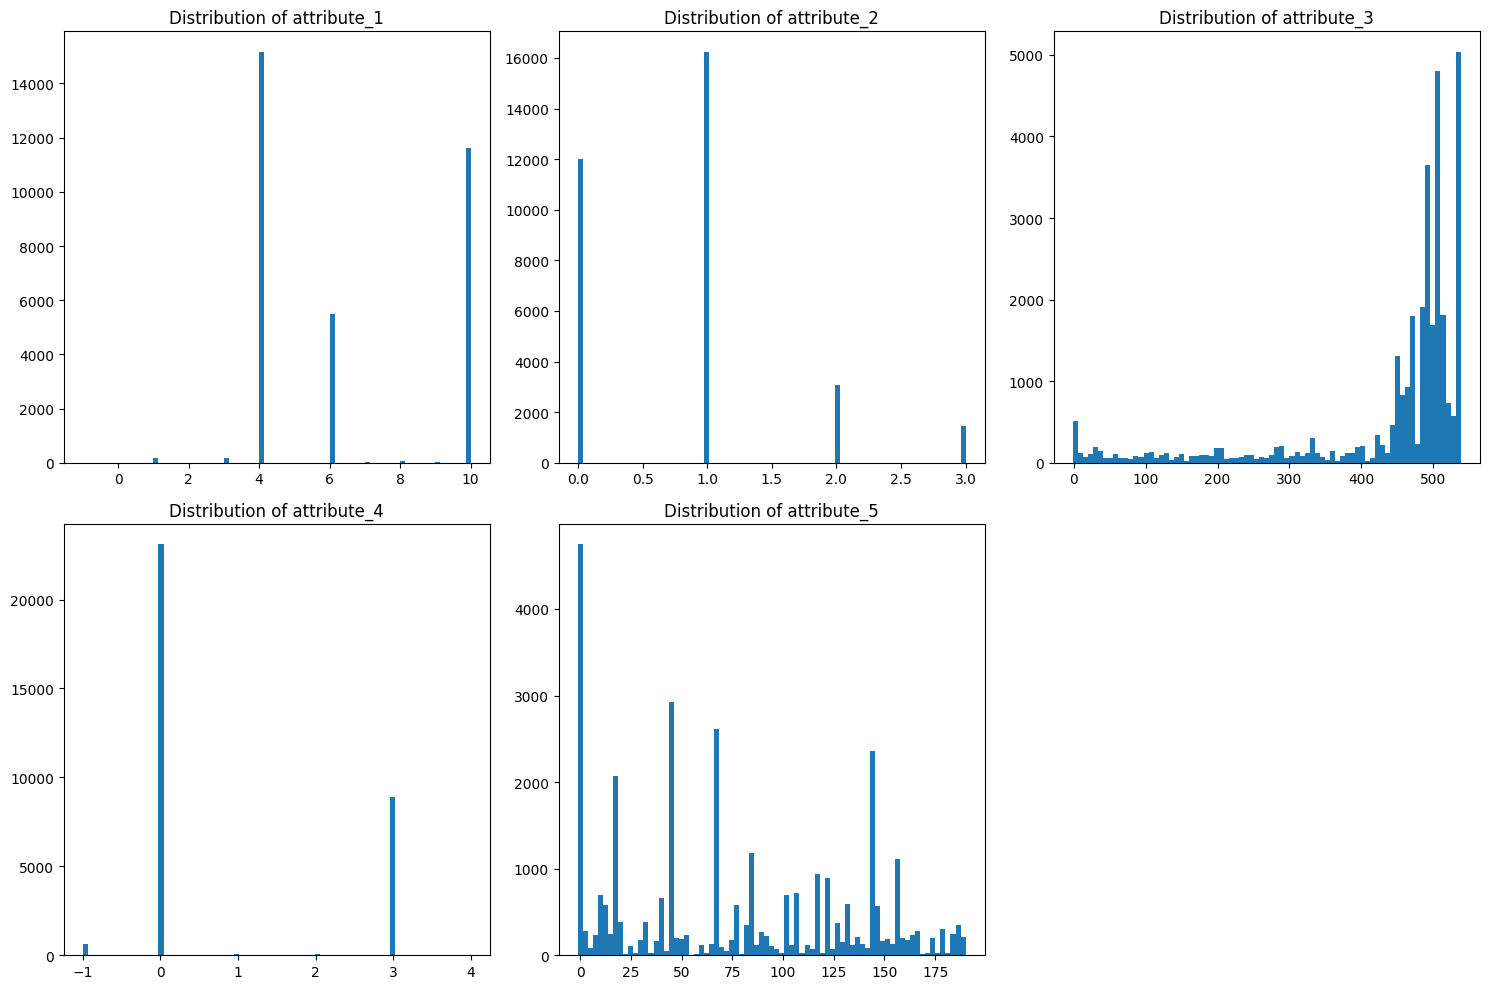

In [ ]:
# List of attributes to plot
attributes = ['attribute_1', 'attribute_2', 'attribute_3', 'attribute_4', 'attribute_5']

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot histogram for each attribute
for i, attribute in enumerate(attributes):
    axes[i].hist(catalog_df[attribute], bins=77)
    axes[i].set_title(f'Distribution of {attribute}')

# Remove empty subplot (since we have 5 attributes)
fig.delaxes(axes[5])

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

Number of unique items in columns

In [ ]:
for attribute in attributes:
    print(f"Unique values in {attribute}: {catalog_df[attribute].nunique()}")
print(f"Unique values in manufacturer_id: {catalog_df['manufacturer_id'].nunique()}")


Unique values in attribute_1: 12
Unique values in attribute_2: 4
Unique values in attribute_3: 540
Unique values in attribute_4: 6
Unique values in attribute_5: 192
Unique values in manufacturer_id: 1515


Filling -1 values with mode


In [ ]:
for attribute in attributes:
  catalog_df[attribute] = catalog_df[attribute].replace(-1, catalog_df[attribute].mode()[0])

Percentages of column values



In [ ]:
for i, attribute in enumerate(attributes):
  print(catalog_df[attribute].value_counts(dropna=False, normalize=True).head())
  print()

attribute_1
4     0.462778
10    0.354253
6     0.167684
1     0.005827
3     0.005431
Name: proportion, dtype: float64

attribute_2
1    0.495423
0    0.365694
2    0.094124
3    0.044758
Name: proportion, dtype: float64

attribute_3
536    0.135160
503    0.091988
491    0.085398
487    0.027154
474    0.024652
Name: proportion, dtype: float64

attribute_4
0    0.723609
3    0.271693
2    0.002502
1    0.001770
4    0.000427
Name: proportion, dtype: float64

attribute_5
-1      0.130095
 66     0.077984
 144    0.071394
 17     0.063125
 46     0.041646
Name: proportion, dtype: float64



Filling NULL values of 'categories' column \\
We grouped by attribute_1, attribute_2 and attribute_3 because they have relatively smaller number of unique values.We found the mode for each group. \\
Then, we fill the NULL values with the corresponding mode values. \\


In [ ]:
# Step 1: Calculate the mode for each group
mode_values = catalog_df.groupby(['attribute_1', 'attribute_2','attribute_3'])['categories'].agg(lambda x: pd.Series.mode(x).iloc[0] if not pd.Series.mode(x).empty else None)

# Step 2: Map the mode values back to the original DataFrame
catalog_df['mode_fill'] = catalog_df.set_index(['attribute_1', 'attribute_2','attribute_3']).index.map(mode_values)

# Step 3: Fill NaN values in 'categories' with the corresponding mode values
catalog_df['categories'].fillna(catalog_df['mode_fill'], inplace=True)

# Drop the temporary 'mode_fill' column if no longer needed
catalog_df.drop(columns=['mode_fill'], inplace=True)
catalog_df['categories'].fillna(catalog_df['categories'].mode()[0],inplace=True)

In [ ]:
catalog_df.isna().sum()

,0
product_id,0
manufacturer_id,0
attribute_1,0
attribute_2,0
attribute_3,0
attribute_4,0
attribute_5,0
categories,0


Converting the values to string

In [ ]:
catalog_df['categories'] = catalog_df['categories'].astype(str)


### Category dataframe


Dropping duplicate values

In [ ]:
category_map_df = category_map_df.drop_duplicates(subset=['category_id'])
category_map_df[category_map_df['category_id'].duplicated(keep=False)]

,category_id,parent_category_id


In [ ]:
category_map_df[category_map_df['category_id']==category_map_df['parent_category_id']]['category_id'].values


array([3898])

In [ ]:
def category_mapper(df):
    """
    Maps categories in a DataFrame to identify top-level categories and update relationships
    between category IDs and their parent category IDs.

    Args:
        df (pd.DataFrame): A DataFrame containing 'category_id' and 'parent_category_id' columns.

    Returns:
        tuple: A modified DataFrame and a filtered list of parent category IDs.
    """
    # Step 1: Identify top-level categories (where category_id equals parent_category_id).
    # These are categories that are considered "self-referencing."
    top_nodes = df[df['category_id'] == df['parent_category_id']]['category_id'].values

    # Step 2: Create a copy of the input DataFrame to avoid modifying the original DataFrame.
    category_map_df_filtered = df.copy()

    # Step 3: Update parent_category_id for categories that are children of top-level categories.
    # For rows where 'parent_category_id' is in the list of top-level categories,
    # set 'parent_category_id' to be the same as 'category_id' to make them top categories.
    category_map_df_filtered.loc[
        category_map_df_filtered['parent_category_id'].isin(top_nodes),
        'parent_category_id'
    ] = category_map_df_filtered['category_id']

    # Step 4: Identify categories where 'category_id' equals 'parent_category_id' after the update.
    # These are now considered "self-referencing" categories.
    parent_list = category_map_df_filtered[
        category_map_df_filtered['category_id'] == category_map_df_filtered['parent_category_id']
    ]['category_id'].values

    # Step 5: Filter the parent_list to include only category IDs that are less than or equal to 3898.
    # This threshold is used to exclude categories above 3898, which are not considered parent categories.
    parent_list = [x for x in parent_list if x <= 3898]

    # Step 6: Return the modified DataFrame and the filtered list of parent category IDs.
    return category_map_df_filtered, parent_list


In [ ]:
# Converting category column to list
catalog_df['categories'] = catalog_df['categories'].apply(ast.literal_eval)
catalog_df['categories'] = catalog_df['categories'].apply(lambda x: sorted(x))
catalog_df.loc[0,'categories']


[855, 2890, 3908, 3909]

In [ ]:
def category_row_transform(row, df_map, parents):
    """
    Transforms the 'categories' column of a DataFrame row to include only categories
    that are in the 'parents' list or can be mapped to a parent category using 'df_map'.

    Args:
        row (pd.Series): A row from a DataFrame containing a 'categories' column.
        df_map (pd.DataFrame): A mapping DataFrame with 'category_id' and 'parent_category_id'.
        parents (set): A set of parent category IDs to filter the categories.

    Returns:
        pd.Series: The modified row with updated 'categories'.
    """
    # Extract the 'categories' list from the row.
    category = row['categories']

    # Initialize a list to hold transformed category elements.
    element_list = []

    # Iterate through each category element in the list.
    for element in category:
        # Find the parent category by traversing the mapping DataFrame until a parent is found.
        while element not in parents:
            element = df_map.loc[df_map['category_id'] == element, 'parent_category_id'].values[0]

        # Add the resolved parent category to the list.
        element_list.append(element)

    # Remove duplicate categories by converting the list to a set and back to a list.
    category = list(set(element_list))

    # Update the 'categories' column in the row with the transformed list.
    row['categories'] = category

    # Return the modified row.
    return row


In [ ]:
category_map_df_filtered, parent_list = category_mapper(category_map_df)


Arranging the category mapping dataframe


In [ ]:
category_map_df_filtered.loc[category_map_df_filtered['parent_category_id'] >= 3898, 'parent_category_id'] = 3898
category_map_df_filtered = category_map_df_filtered.drop_duplicates(subset=['category_id', 'parent_category_id'])

Transforming the category column


In [ ]:
catalog_df_transformed = catalog_df.apply(lambda row: category_row_transform(row,category_map_df_filtered,parent_list),axis=1)

FEATURE ENGINEERING

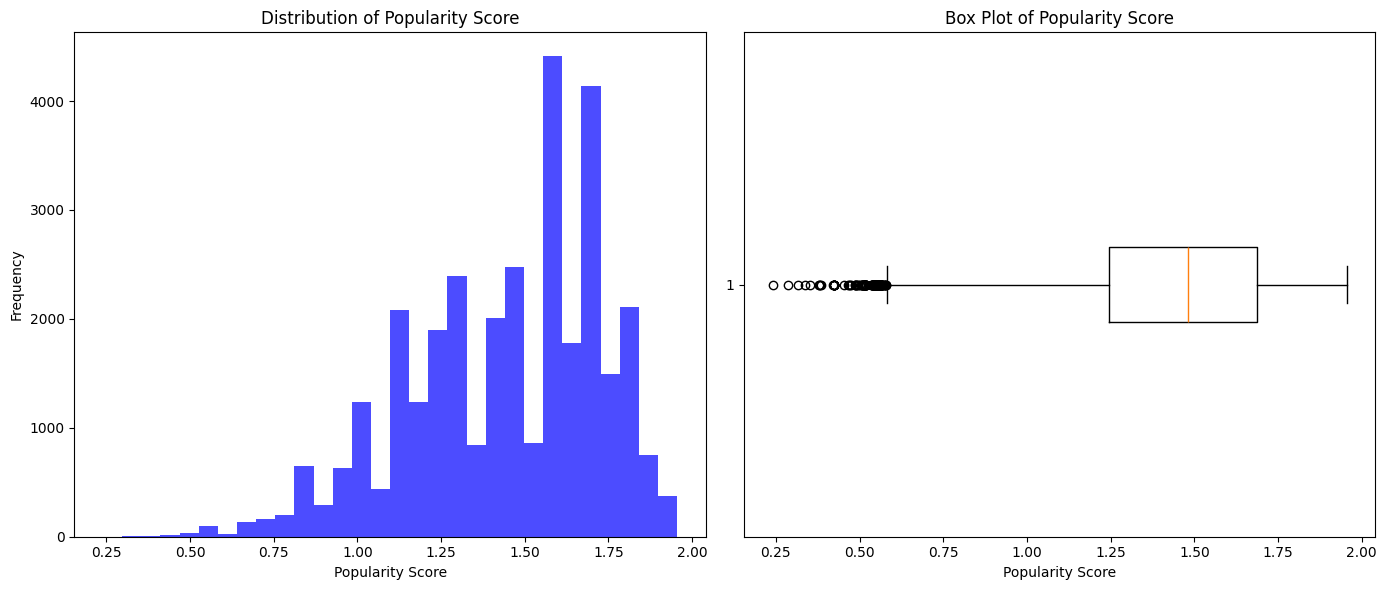

In [ ]:
def calculate_popularity_score(catalog_df_transformed):
    """
    Calculate the popularity score for each product in catalog_df_transformed.

    The popularity score is the sum of the ratios of each attribute value's
    frequency in the dataset to the total number of products.
    """
    # Initialize popularity score column
    catalog_df_transformed['popularity_score'] = 0.0

    # List of columns to consider for calculating the score
    columns = ['manufacturer_id', 'attribute_1', 'attribute_2', 'attribute_3', 'attribute_4', 'attribute_5']
    n = len(catalog_df_transformed)

    # Compute the frequency of each value for all columns
    for col in columns:
        value_counts = catalog_df_transformed[col].value_counts()
        value_ratios = value_counts / n

        # Add the ratio for each value to the popularity score
        catalog_df_transformed['popularity_score'] += catalog_df_transformed[col].map(value_ratios)

    return catalog_df_transformed

catalog_df_transformed = calculate_popularity_score(catalog_df_transformed)

# Assuming catalog_df_transformed is already defined
# catalog_df_transformed = pd.read_csv('your_file.csv')

# Create a figure with subplots
plt.figure(figsize=(14, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(catalog_df_transformed["popularity_score"], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Popularity Score')
plt.xlabel('Popularity Score')
plt.ylabel('Frequency')

# Box Plot
plt.subplot(1, 2, 2)
plt.boxplot(catalog_df_transformed["popularity_score"], vert=False)
plt.title('Box Plot of Popularity Score')
plt.xlabel('Popularity Score')

# Show plots
plt.tight_layout()
plt.show()



Clustering the customers with KMeans Clustering

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans

# Columns to use for clustering
nominal_columns = ['manufacturer_id', 'attribute_1', 'attribute_2', 'attribute_3', 'attribute_4', 'attribute_5']
numerical_column = ['popularity_score']

# One-hot encode nominal columns
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
nominal_encoded = encoder.fit_transform(catalog_df_transformed[nominal_columns])

# Standardize the numerical column
scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(catalog_df_transformed[numerical_column])

# Combine the encoded nominal and scaled numerical features
clustering_features = np.hstack([nominal_encoded, numerical_scaled])

# Apply k-means clustering
kmeans = KMeans(n_clusters=15, random_state=42)  # Adjust n_clusters as needed
catalog_df_transformed['cluster'] = kmeans.fit_predict(clustering_features)

In [ ]:
nominal_encoded.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(32776, 2266)

In [ ]:
catalog_df_transformed['cluster'].value_counts()

,count
cluster,
3,5703
6,3153
0,3108
4,2657
1,2613
10,2339
5,2223
8,2056
9,1884


Applying associative rules with apriori algorithm

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

In [ ]:
transactions = transactions_df.groupby("customer_id")["product_id"].apply(list)
transactions.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,product_id
customer_id,
0,"[20664, 15083, 12468, 12505, 1505, 26387, 2066..."
1,"[19325, 20748, 11188, 20562, 4770, 29047, 2911..."
2,"[30829, 23476, 9779, 15445, 2742, 28815, 23635..."
3,"[31799, 26152, 23687, 4424, 8935, 27122, 6738,..."
4,"[18860, 30779, 20518, 32609, 24047, 29546, 293..."


In [ ]:
# Transform the data
te = TransactionEncoder()
te_data = te.fit(transactions).transform(transactions)
te_df = pd.DataFrame(te_data, columns=te.columns_)

# Apply the Apriori algorithm
frequent_itemsets = apriori(te_df, min_support=0.01, use_colnames=True)

# Pass `num_itemsets` explicitly to avoid the error
rules = association_rules(frequent_itemsets, num_itemsets=len(frequent_itemsets), metric="lift", min_threshold=1.1)

# Output the results
print("Frequent Itemsets:")
frequent_itemsets

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Frequent Itemsets:


,support,itemsets
0,0.040140,(395)
1,0.013221,(461)
2,0.012463,(550)
3,0.034592,(637)
4,0.011964,(875)
...,...,...
275,0.013633,"(20131, 18630)"
276,0.029520,"(29657, 18630)"
277,0.020937,"(29657, 20131)"
278,0.010295,"(29657, 23050)"


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


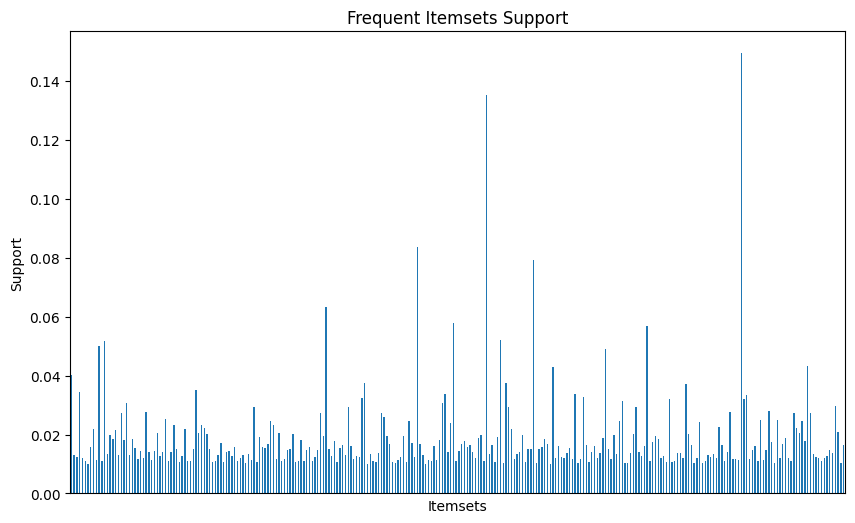

In [ ]:
frequent_itemsets['support'].plot(kind='bar', figsize=(10, 6))
plt.title('Frequent Itemsets Support')
plt.xlabel('Itemsets')
plt.ylabel('Support')
plt.xticks([])
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


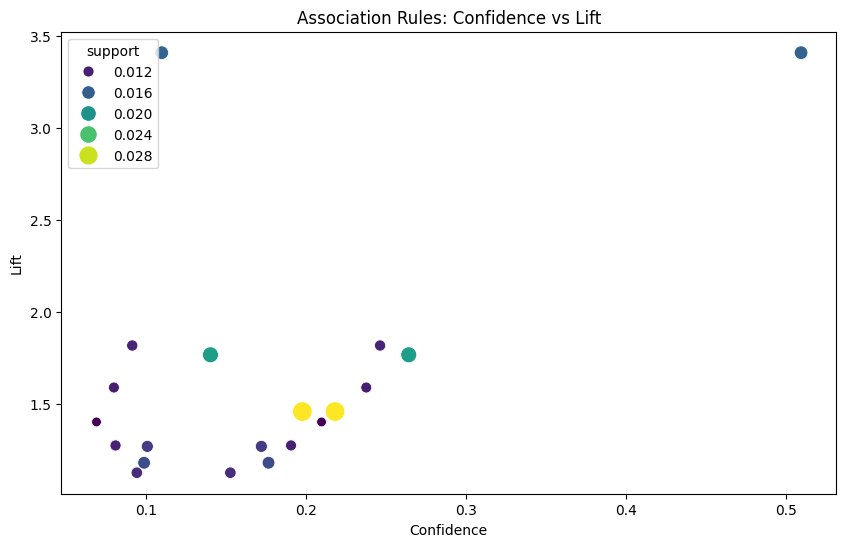

In [ ]:
# Plot association rules with confidence vs lift
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rules, x='confidence', y='lift', hue='support', size='support', sizes=(50, 200), palette='viridis')
plt.title('Association Rules: Confidence vs Lift')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


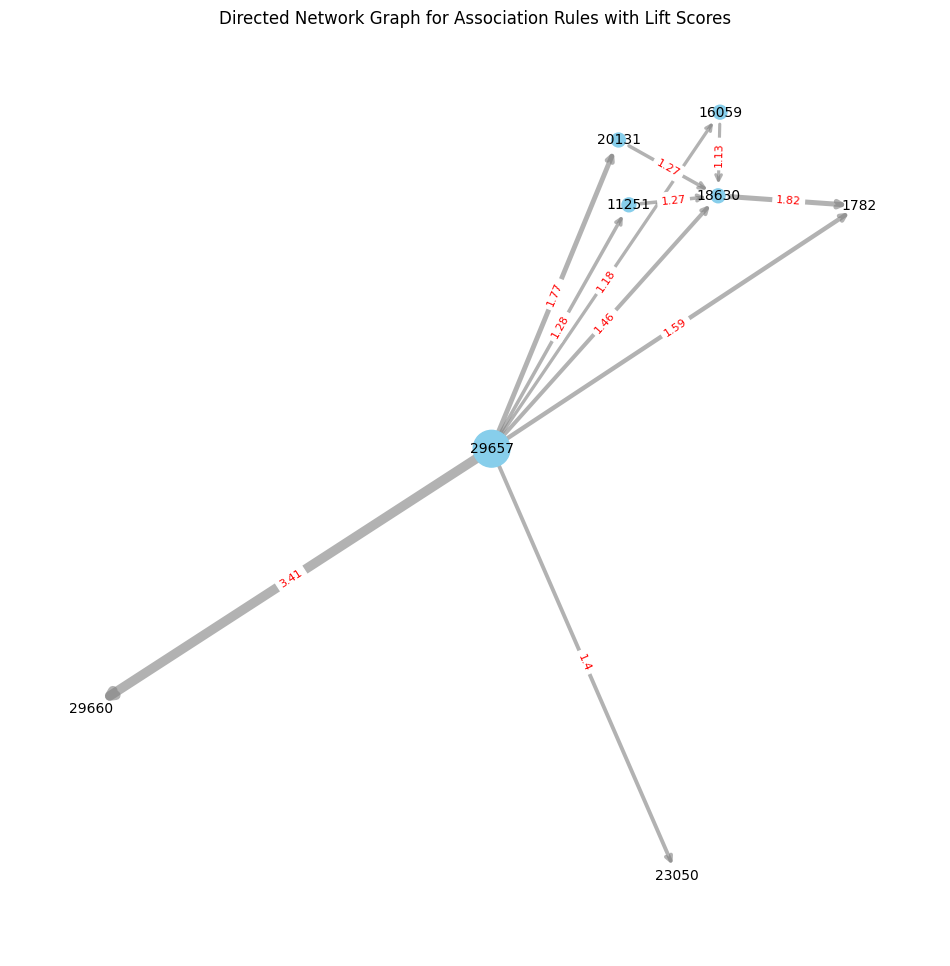

In [ ]:
import networkx as nx

G = nx.DiGraph()

for _, rule in rules.iterrows():
    antecedents = rule['antecedents']
    consequents = rule['consequents']
    lift = rule['lift']

    if lift > 1.1:
        for item in antecedents:
            for item2 in consequents:
                if not G.has_edge(item2, item):
                    G.add_edge(item, item2, weight=lift)

# Set up the plot size
plt.figure(figsize=(12, 12))

# Apply the spring layout (force-directed layout)
pos = nx.spring_layout(G, k=0.15, iterations=30, seed=42)

# Draw nodes with larger size based on degree (number of connections)
node_sizes = [len(list(G.neighbors(node))) * 100 for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue')

# Draw directed edges with width proportional to lift (stronger lifts = thicker edges)
edges = G.edges(data=True)
edge_widths = [edge[2]['weight'] * 2 for edge in edges]  # Scale lift for edge thickness
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.6, edge_color='gray', arrows=True, arrowstyle='->', arrowsize=10)

# Draw labels on nodes
node_labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)

# Draw labels on edges (lift scores)
edge_labels = {(edge[0], edge[1]): f"{round(edge[2]['weight'], 2)}"
               for edge in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='red')

# Display the title and show the plot
plt.title('Directed Network Graph for Association Rules with Lift Scores')
plt.axis('off')  # Hide axis
plt.show()

DBSCAN algorithm to cluster categories column for customer attributes

In [ ]:
from itertools import combinations
from collections import defaultdict
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Flatten transactions into category pairs
def build_cooccurrence_matrix(df):
    cooccurrence = defaultdict(int)

    # Iterate through each product's category list
    for categories in df['categories']:
        if isinstance(categories, list):
            # Generate all unique pairs of categories
            for pair in combinations(categories, 2):
                cooccurrence[tuple(sorted(pair))] += 1

    # Convert to DataFrame
    cooccurrence_df = pd.DataFrame(
        [(k[0], k[1], v) for k, v in cooccurrence.items()],
        columns=['Category1', 'Category2', 'Count']
    )
    return cooccurrence_df

# Build the co-occurrence matrix
cooccurrence_df = build_cooccurrence_matrix(catalog_df_transformed)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Step 2: Convert co-occurrence into a similarity matrix
# Create a mapping of categories to indices
all_categories = set(cooccurrence_df['Category1']).union(cooccurrence_df['Category2'])
category_index = {category: i for i, category in enumerate(all_categories)}

# Initialize a square matrix of zeros
cooccurrence_matrix = np.zeros((len(all_categories), len(all_categories)))

# Fill in the matrix with co-occurrence counts
for _, row in cooccurrence_df.iterrows():
    i, j = category_index[row['Category1']], category_index[row['Category2']]
    cooccurrence_matrix[i, j] = row['Count']
    cooccurrence_matrix[j, i] = row['Count']  # Symmetric matrix

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity

normalized_matrix = cooccurrence_matrix / np.max(cooccurrence_matrix)

# Step 2: Compute the similarity matrix
similarity_matrix = cosine_similarity(normalized_matrix)

# Step 3: Convert similarity to a distance matrix
distance_matrix = 1.000000001 - similarity_matrix  # DBSCAN requires distances

# Step 4: Apply DBSCAN
eps = 0.15  # Adjust epsilon based on your dataset
min_samples = 2  # Minimum samples for a core point
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')

# Fit the model
cluster_labels = dbscan_model.fit_predict(distance_matrix)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train_start = transactions_df.merge(catalog_df_transformed, on='product_id', how='left')
train_start.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,product_id,purchase_date,quantity,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,categories,popularity_score,cluster
0,38769,3477,2020-06-01,1,186,6,0,196,0,45,"[3056, 3898, 1543]",1.287649,13
1,42535,30474,2020-06-01,1,193,10,3,229,3,132,"[1666, 621, 3056, 3898, 2364]",0.691878,1
2,42535,15833,2020-06-01,1,1318,4,1,455,0,108,"[3624, 252, 519]",1.709727,3
3,42535,20131,2020-06-01,1,347,4,0,291,3,44,"[1763, 3624, 2793, 2762, 621, 1682, 1557, 2231...",1.127502,10
4,42535,4325,2020-06-01,1,539,6,0,303,0,45,"[3624, 1682, 2231, 3898, 2364]",1.288809,13


In [ ]:
# Map categories back to clusters
category_cluster_mapping = {category: cluster for category, cluster in zip(category_index.keys(), cluster_labels)}

# Step 4: Assign clusters to products
def assign_product_cluster(categories, cluster_mapping):
    product_clusters = [cluster_mapping[category] for category in categories if category in cluster_mapping]
    return max(set(product_clusters), key=product_clusters.count) if product_clusters else -1  # Assign most common cluster
train_start_dbscan = train_start.copy()
train_start_dbscan['category_cluster'] = train_start['categories'].apply(
    lambda x: assign_product_cluster(x, category_cluster_mapping)
)

train_start_dbscan.drop(columns=['categories'],inplace=True)
train_start_dbscan.sort_values('product_id')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,product_id,purchase_date,quantity,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,popularity_score,cluster,category_cluster
231072,6446,0,2020-07-25,1,389,4,2,469,0,-1,1.430864,2,-1
154402,37159,1,2020-07-06,1,1006,4,0,487,3,66,1.207255,10,0
1001687,11091,1,2021-01-19,1,1006,4,0,487,3,66,1.207255,10,0
354344,8967,1,2020-08-24,2,1006,4,0,487,3,66,1.207255,10,0
646206,31960,1,2020-11-03,1,1006,4,0,487,3,66,1.207255,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
455933,40719,32772,2020-09-18,1,333,6,1,503,0,17,1.542867,4,0
275406,28671,32772,2020-08-05,1,333,6,1,503,0,17,1.542867,4,0
324440,28155,32773,2020-08-16,1,284,4,1,531,0,148,1.692549,3,0
602256,21417,32775,2020-10-23,1,1156,4,2,282,0,33,1.304461,2,0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Ensure the purchase_date column is in datetime format
train_start['purchase_date'] = pd.to_datetime(train_start['purchase_date'])

# Sort the dataframe by customer_id, cluster, and purchase_date
train_start = train_start.sort_values(by=['customer_id', 'cluster', 'purchase_date'])

# Group by customer_id and cluster, calculate the day difference
train_start['day_diff'] = train_start.groupby(['customer_id', 'cluster'])['purchase_date'].diff().dt.days

# Replace day_diff = 0 with the next valid day_diff in the group
def propagate_day_diff(group):
    day_diffs = group['day_diff'].values
    n = len(day_diffs)

    # Propagate day_diff for all elements except the last one
    for i in range(n - 1):
        # If the current day_diff is 0, find the next valid day_diff
        if day_diffs[i] == 0:
            for j in range(i + 1, n):
                if day_diffs[j] > 0:  # Find the next positive day_diff
                    day_diffs[i] = day_diffs[j]
                    break
            else:
                # If no next valid value, set to NaN
                day_diffs[i] = None

    # Check the last element (the edge case)
    if day_diffs[-1] == 0:
        # Try to propagate from the previous value
        for i in range(n - 2, -1, -1):
            if day_diffs[i] > 0:
                day_diffs[-1] = day_diffs[i]
                break
        else:
            # If no valid value, set to NaN
            day_diffs[-1] = None

    return pd.Series(day_diffs, index=group.index)

# Apply the function to propagate day_diff within each group of customer_id and cluster
train_start['day_diff'] = train_start.groupby(['customer_id', 'cluster'], group_keys=False).apply(propagate_day_diff)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-38-dd8988effd1e>:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_start['day_diff'] = train_start.groupby(['customer_id', 'cluster'], group_keys=False).apply(propagate_day_diff)


In [ ]:
def categorize_day_diff(day_diff):
    if pd.isna(day_diff):  # Handle NaN values
        return 0
    elif 1 <= day_diff <= 7:
        return 1
    elif 8 <= day_diff <= 14:
        return 2
    elif 15 <= day_diff <= 21:
        return 3
    elif 22 <= day_diff <= 28:
        return 4
    else:
        return 0

# Apply the function to the 'day_diff' column
train_start['day_diff_category'] = train_start['day_diff'].apply(categorize_day_diff)

# Check the results
print(train_start['day_diff_category'].value_counts())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


day_diff_category
0    804753
1     69663
2     67905
3     66488
4     62729
Name: count, dtype: int64


In [ ]:
train_start['day_diff'].isna().sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0

In [ ]:
# Calculate the maximum day difference for each product-cluster pair
train_start['max_day_diff'] = train_start.groupby(['customer_id', 'cluster'])['day_diff'].transform('max')
train_start['min_day_diff'] = train_start.groupby(['customer_id', 'cluster'])['day_diff'].transform('min')

train_start.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,product_id,purchase_date,quantity,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,categories,popularity_score,cluster,day_diff,day_diff_category,max_day_diff,min_day_diff
268197,0,12468,2020-08-03,1,1288,10,0,421,3,3,"[2723, 519]",1.009946,1,NaN,0,109.0,56.0
709719,0,9325,2020-11-20,1,107,6,0,308,3,17,"[3624, 1682, 3898]",0.872956,1,109.0,0,109.0,56.0
978366,0,29956,2021-01-15,1,1383,6,0,537,3,122,"[3898, 1682, 2364]",0.848365,1,56.0,0,109.0,56.0
334333,0,12505,2020-08-18,1,53,4,3,474,0,-1,"[3616, 2762, 298, 686, 366, 2231, 600, 3898]",1.386136,2,NaN,0,NaN,NaN
22146,0,20664,2020-06-05,1,408,4,0,284,0,66,[2346],1.635129,8,NaN,0,126.0,10.0


In [ ]:
train_start["day_diff"].value_counts().head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count
day_diff,
1.0,10597
14.0,10289
7.0,10210
8.0,9998
6.0,9991
21.0,9974
5.0,9927
13.0,9916
15.0,9842


In [ ]:
# prompt: see how many rows contain na value

# Count rows with at least one NA value in the DataFrame
na_rows = train_start.isna().any(axis=1).sum()
print(f"Number of rows with at least one NA value: {na_rows}")

Number of rows with at least one NA value: 377852


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# prompt: drop rows with null values
# Drop rows with any null values
train_start.dropna(inplace=True)

# Verify that there are no more null values
na_rows = train_start.isna().any(axis=1).sum()
print(f"Number of rows with at least one NA value after dropping: {na_rows}")
print(train_start['day_diff_category'].value_counts())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of rows with at least one NA value after dropping: 0
day_diff_category
0    426901
1     69663
2     67905
3     66488
4     62729
Name: count, dtype: int64


In [ ]:
# Assuming 'train_start' DataFrame is already loaded and processed as in the provided code

# Identify rows where 'day_diff_category' is 0
rows_to_remove = train_start[train_start['day_diff_category'] == 0]

# Calculate the number of rows to remove (80%)
num_rows_to_remove = int(0.8 * len(rows_to_remove))

# Randomly select rows to remove
rows_to_remove = rows_to_remove.sample(n=num_rows_to_remove, random_state=42) # Set a random state for reproducibility

# Get the indices of the rows to remove
indices_to_remove = rows_to_remove.index

# Remove the selected rows from the DataFrame
train_start = train_start.drop(indices_to_remove)

# Now 'train_start' contains the DataFrame with 80% of rows with day_diff_category == 0 removed.
print(train_start['day_diff_category'].value_counts())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


day_diff_category
0    85381
1    69663
2    67905
3    66488
4    62729
Name: count, dtype: int64


In [ ]:
X

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,product_id,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,popularity_score,cluster,max_day_diff,min_day_diff
978365,0,6446,839,4,0,18,0,81,1.560990,8,126.0,10.0
1031053,0,13146,193,4,0,453,0,108,1.596381,8,126.0,10.0
779709,0,31683,1371,4,0,484,3,175,1.120423,10,45.0,7.0
819666,0,28231,193,4,3,468,3,108,0.812942,10,45.0,7.0
806863,1,18283,648,10,0,6,3,84,1.015743,1,93.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...
256535,46136,6150,185,4,0,131,3,151,1.105046,10,60.0,58.0
194855,46136,11002,322,4,3,536,0,144,1.492006,11,89.0,17.0
256517,46136,11199,473,4,0,321,0,144,1.625610,11,89.0,17.0
256534,46136,27944,18,4,0,131,0,144,1.628783,11,89.0,17.0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Drop unnecessary columns
train_data = train_start.drop(columns=['quantity', 'day_diff', 'purchase_date','categories'])

# Define the features (X) and target (y)
X = train_data.drop(columns=['day_diff_category'])  # Features
y = train_data['day_diff_category']  # Target

# Step 1: Sample 40k examples for each class from the original data
train_data_balanced = pd.concat([
    train_data[train_data['day_diff_category'] == label].sample(40000, random_state=42)
    for label in y.unique()
])

# Step 2: Add 5k more rows for day_diff_category == 4
day_4_data = train_data[train_data['day_diff_category'] == 4]
additional_data_4 = day_4_data.sample(10000, random_state=42)

# Add the new 5k samples to the balanced dataset
train_data_balanced = pd.concat([train_data_balanced, additional_data_4])

# Step 3: Separate the features and target for the balanced dataset
X_balanced = train_data_balanced.drop(columns=['day_diff_category'])
y_balanced = train_data_balanced['day_diff_category']

# Step 4: Separate the remaining data for testing (not part of the 40k samples)
remaining_data = train_data[~train_data.index.isin(train_data_balanced.index)]
X_test = remaining_data.drop(columns=['day_diff_category'])
y_test = remaining_data['day_diff_category']

# Step 5: Split the 40k per class data into training and validation (no test data yet)
X_train = X_balanced
y_train = y_balanced

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=12, min_samples_split=10, max_features=5)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy: 0.5730
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.47      0.64     45381
           1       0.42      0.99      0.59     29663
           2       0.53      0.60      0.56     27905
           3       0.64      0.44      0.52     26488
           4       0.72      0.36      0.48     22729

    accuracy                           0.57    152166
   macro avg       0.66      0.57      0.56    152166
weighted avg       0.70      0.57      0.57    152166



In [ ]:
test_df= pd.read_csv("drive/MyDrive/collab_files/test.csv")
test_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,customer_id,product_id,prediction
0,0,0,20664,NaN
1,1,0,28231,NaN
2,2,13,2690,NaN
3,3,15,1299,NaN
4,4,15,20968,NaN


In [ ]:
train_data.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(352166, 13)

In [ ]:
# Remove duplicates from train_data based on customer_id and product_id
train_data_unique = train_data.drop_duplicates(subset=['customer_id', 'product_id'])

# Perform a left join between test_df and the deduplicated train_data
test = pd.merge(test_df, train_data_unique, on=['product_id','customer_id'], how='left')

# Verify that result has the same length as test_df
test.shape # This should be (10000, n) where n is the number of columns after the merge


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(10000, 15)

In [ ]:
unique_products = train_data_unique.drop(columns=['customer_id']).drop_duplicates(subset=['product_id'])
unique_products.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,product_id,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,popularity_score,cluster,day_diff_category,max_day_diff,min_day_diff
978365,6446,839,4,0,18,0,81,1.560990,8,0,126.0,10.0
1031053,13146,193,4,0,453,0,108,1.596381,8,2,126.0,10.0
779709,31683,1371,4,0,484,3,175,1.120423,10,2,45.0,7.0
819666,28231,193,4,3,468,3,108,0.812942,10,1,45.0,7.0
806863,18283,648,10,0,6,3,84,1.015743,1,4,93.0,24.0


In [ ]:
test = test.drop(columns=['id', 'prediction', 'day_diff_category'])
test.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,product_id,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,popularity_score,cluster,max_day_diff,min_day_diff
0,0,20664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,28231,193.0,4.0,3.0,468.0,3.0,108.0,0.812942,10.0,45.0,7.0
2,13,2690,406.0,4.0,3.0,491.0,0.0,66.0,1.404503,2.0,78.0,9.0
3,15,1299,1056.0,4.0,0.0,474.0,0.0,108.0,1.598273,8.0,81.0,2.0
4,15,20968,1315.0,4.0,0.0,444.0,0.0,144.0,1.629912,11.0,32.0,20.0


In [ ]:
# Find rows with null values in any column
null_rows = test[test.isnull().any(axis=1)]

# Display customer_id and product_id of rows with null values
null_rows[['customer_id', 'product_id']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,product_id
0,0,20664
5,20,8272
8,34,31244
14,78,12635
15,79,21856
...,...,...
9986,46074,21372
9987,46080,32349
9988,46094,395
9989,46095,19519


In [ ]:
null_filled = pd.merge(null_rows[['customer_id', 'product_id']], unique_products, on='product_id', how='left')
null_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2635 entries, 0 to 2634
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        2635 non-null   int64  
 1   product_id         2635 non-null   int64  
 2   manufacturer_id    2512 non-null   float64
 3   attribute_1        2512 non-null   float64
 4   attribute_2        2512 non-null   float64
 5   attribute_3        2512 non-null   float64
 6   attribute_4        2512 non-null   float64
 7   attribute_5        2512 non-null   float64
 8   popularity_score   2512 non-null   float64
 9   cluster            2512 non-null   float64
 10  day_diff_category  2512 non-null   float64
 11  max_day_diff       2512 non-null   float64
 12  min_day_diff       2512 non-null   float64
dtypes: float64(11), int64(2)
memory usage: 267.7 KB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
new_test = pd.concat([test.dropna(), null_filled])
new_test

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,product_id,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,popularity_score,cluster,max_day_diff,min_day_diff,day_diff_category
1,0,28231,193.0,4.0,3.0,468.0,3.0,108.0,0.812942,10.0,45.0,7.0,NaN
2,13,2690,406.0,4.0,3.0,491.0,0.0,66.0,1.404503,2.0,78.0,9.0,NaN
3,15,1299,1056.0,4.0,0.0,474.0,0.0,108.0,1.598273,8.0,81.0,2.0,NaN
4,15,20968,1315.0,4.0,0.0,444.0,0.0,144.0,1.629912,11.0,32.0,20.0,NaN
6,24,11340,406.0,10.0,0.0,504.0,0.0,17.0,1.526208,6.0,33.0,4.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2630,46074,21372,1111.0,4.0,0.0,160.0,0.0,163.0,1.569990,8.0,95.0,2.0,2.0
2631,46080,32349,1445.0,10.0,3.0,536.0,0.0,95.0,1.268886,7.0,86.0,65.0,0.0
2632,46094,395,745.0,4.0,0.0,399.0,3.0,163.0,1.110142,10.0,74.0,74.0,0.0
2633,46095,19519,1297.0,4.0,1.0,514.0,0.0,187.0,1.705943,3.0,40.0,40.0,0.0


In [ ]:
# prompt: change the null values in columns with 0

# Fill NaN values with 0 in all columns of the 'result' DataFrame
new_test.fillna(-1, inplace=True)
null_counts = train_start.isnull().sum()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
new_test.shape, X_train.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


((10000, 13), (210000, 12))

In [ ]:
X_train.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,product_id,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,popularity_score,cluster,max_day_diff,min_day_diff
841894,15528,10849,827,10,0,348,0,95,1.452465,6,138.0,19.0
994337,41443,30006,1113,4,0,444,3,44,1.128997,10,90.0,90.0
544287,29792,19400,366,6,0,498,0,13,1.270167,13,43.0,43.0
422366,2873,28708,504,10,0,441,3,84,1.024530,1,76.0,19.0
915731,39005,29340,948,4,2,486,3,144,0.913870,10,144.0,21.0


In [ ]:
new_test.drop(columns=['day_diff_category']).head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,product_id,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,popularity_score,cluster,max_day_diff,min_day_diff
1,0,28231,193.0,4.0,3.0,468.0,3.0,108.0,0.812942,10.0,45.0,7.0
2,13,2690,406.0,4.0,3.0,491.0,0.0,66.0,1.404503,2.0,78.0,9.0
3,15,1299,1056.0,4.0,0.0,474.0,0.0,108.0,1.598273,8.0,81.0,2.0
4,15,20968,1315.0,4.0,0.0,444.0,0.0,144.0,1.629912,11.0,32.0,20.0
6,24,11340,406.0,10.0,0.0,504.0,0.0,17.0,1.526208,6.0,33.0,4.0


In [ ]:
predictions = rf_model.predict(new_test.drop(columns=['day_diff_category']))
predictions[new_test['attribute_1'] == -1] = 0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
new_test[new_test['attribute_1']==-1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,customer_id,product_id,manufacturer_id,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,popularity_score,cluster,max_day_diff,min_day_diff,day_diff_category
14,169,29497,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
15,186,28135,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
16,190,24243,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
20,232,27629,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
68,1210,26616,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2565,45077,9413,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2569,45126,1592,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2571,45126,12956,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2623,45875,2420,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [ ]:
# Prepare the output DataFrame
output_df = pd.DataFrame({
    'id': test_df['id'],
    'customer_id': test_df['customer_id'],
    'product_id': test_df['product_id'],
    'prediction': predictions
})
# Optionally, save the output to a CSV file
output_df.to_csv('predictions_output.csv', index=False)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
